In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#df = pd.read_csv('C:\\Users\\18053\\Desktop\\Portfolio Projects\\Weather and Energy\\Energy Demand Data\\CAISO-demand-20210825.csv')

In [3]:
#df.head()

In [4]:
#daily_energy_demand =df.iloc[2,1:].sum()

In [5]:
#daily_energy_demand 

In [6]:
#date = df.columns[0][-10:]

In [7]:
#date

In [8]:
#masterdf= pd.DataFrame(columns = ['Date', 'Daily Energy Demand'])

In [9]:
#masterdf

In [10]:
#import glob

set search path and glob for files

look for csv files in the input directory

In [11]:
#path = 'C:\\Users\\18053\\Desktop\\Github\\Portfolio Projects\\Weather and Energy\\Energy Demand Data\\All demand data'
#files = glob.glob(path + '/*.csv')


In [12]:
#for f in files:
   
    #temp_df = pd.read_csv(f)
    #daily_energy_demand =temp_df.iloc[2,1:].sum()
    #date = temp_df.columns[0][-10:]
    #masterdf.loc[len(masterdf.index)] = [date,daily_energy_demand] 



In [13]:
#masterdf

In [14]:
### NOTE! i ALREADY ADDED DAY BY THIS POINT, IT SHOULD NOT HAVE BEEN IMPORTED WITH DAY. THAT WAS AN ENGINEERED FEATURE.

In [15]:
masterdf=pd.read_csv('AllEnergyDemand-MasterDF.csv', index_col =0)

In [16]:
masterdf.head()

,Date,Daily Energy Demand,Date_DateObj,Day
0,04/10/2018,7183786.0,2018-04-10,Tuesday
1,04/11/2018,1961585.0,2018-04-11,Wednesday
2,04/12/2018,6670701.0,2018-04-12,Thursday
3,04/13/2018,6643068.0,2018-04-13,Friday
4,04/14/2018,6183992.0,2018-04-14,Saturday


In [17]:
list(masterdf.columns.values)

['Date', 'Daily Energy Demand', 'Date_DateObj', 'Day']

Reordering columns to keep all date columsn next to each other

In [18]:
masterdf= masterdf[['Date', 'Date_DateObj', 'Day', 'Daily Energy Demand']]

In [19]:
masterdf.head(3)

,Date,Date_DateObj,Day,Daily Energy Demand
0,04/10/2018,2018-04-10,Tuesday,7183786.0
1,04/11/2018,2018-04-11,Wednesday,1961585.0
2,04/12/2018,2018-04-12,Thursday,6670701.0


## 2.0 Exploratory Data Analysis

### 2.1 Raw Data Visualization

In [20]:
import seaborn as sns

In [21]:
from datetime import datetime

<AxesSubplot:title={'center':"California's Daily Energy Demand from April 2018- Present"}, xlabel='Date', ylabel='Daily Energy Demand'>

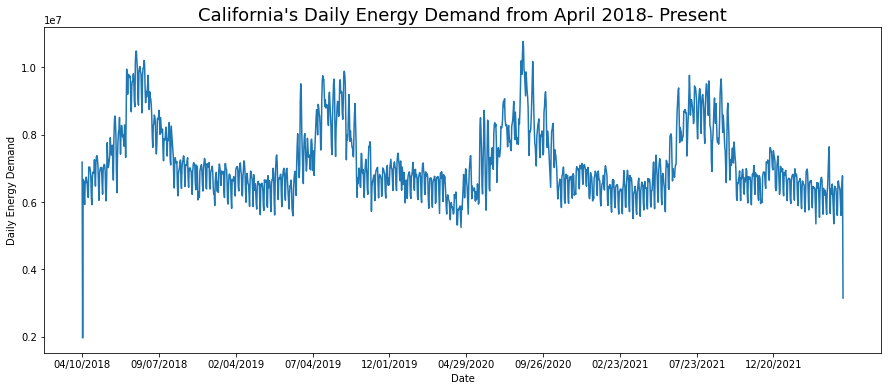

In [22]:
plt.figure(figsize=(15,6))
plt.title("California's Daily Energy Demand from April 2018- Present", fontsize=18)
plt.xticks(np.arange(0, len(masterdf), 150))
sns.lineplot( x ='Date', y= 'Daily Energy Demand', data = masterdf) 

Looks like there are a few outlying data points, notably at the start and end of the date range. This is not surprising because wen scraping the data,the website indicated that some days may have technical errors. I will use zscore to exclude outliers.

### 2.2 Data Cleaning

In [23]:
from scipy.stats import zscore
from scipy import stats

In [24]:
z_scores = stats.zscore(masterdf['Daily Energy Demand'])
abs_z_scores = np.abs(z_scores)
abs_z_scores.count()

1487

In [25]:
outliers = abs_z_scores[abs_z_scores > 3]
outliers.count()

7

Within the 1487 energy values, 7 of them were determined to have an absolute z score of > 3.

In [26]:
masterdf.head(3)

,Date,Date_DateObj,Day,Daily Energy Demand
0,04/10/2018,2018-04-10,Tuesday,7183786.0
1,04/11/2018,2018-04-11,Wednesday,1961585.0
2,04/12/2018,2018-04-12,Thursday,6670701.0


In [27]:
outliers_index = outliers.index.values

In [28]:
outliers_index

array([   1,  105,  106,  860,  861,  862, 1486], dtype=int64)

The outliers have index values of 1,  105,  106,  860,  861,  862, 1486.

Creating a column of index values that can be easily called upon on a function.

In [29]:
masterdf['index'] = masterdf.index.values

In [30]:
len(masterdf)

1487

In [31]:
#function for filling in the outlier values with the average value of the energy demand for the days before and after the outlying data point date
def outlier_fill(energy, index):
        if int(index) in outliers_index:
            #check to make sure the outlier doesn't fall on the first or date day of the series
            if int(index) != 0 and int(index) != 1486:
                energy =  (masterdf.iloc[int(index)+1]['Daily Energy Demand'] + masterdf.iloc[int(index)-1]['Daily Energy Demand'])/2
                return energy
            else: 
                #if the outlying value is the first or last value in the series, it will be replaced with the a duplicate value from the day after or before, respectively
                if int(index) != 1486:
                    energy= masterdf.iloc[int(index)+1]['Daily Energy Demand']
                    return energy
                    
                else:
                    energy = masterdf.iloc[int(index)-1]['Daily Energy Demand']
                    return energy
        else:
            return energy

In [32]:
masterdf['Daily Energy Demand'] = masterdf.apply(lambda x: outlier_fill(x['Daily Energy Demand'], x['index']), axis =1)

In [33]:
masterdf.head(10)

,Date,Date_DateObj,Day,Daily Energy Demand,index
0,04/10/2018,2018-04-10,Tuesday,7183786.0,0
1,04/11/2018,2018-04-11,Wednesday,6927243.5,1
2,04/12/2018,2018-04-12,Thursday,6670701.0,2
3,04/13/2018,2018-04-13,Friday,6643068.0,3
4,04/14/2018,2018-04-14,Saturday,6183992.0,4
5,04/15/2018,2018-04-15,Sunday,5926078.0,5
6,04/16/2018,2018-04-16,Monday,6619344.0,6
7,04/17/2018,2018-04-17,Tuesday,6567013.0,7
8,04/18/2018,2018-04-18,Wednesday,6739403.0,8
9,04/19/2018,2018-04-19,Thursday,6649368.0,9


No longer need the column of index values, dropping it

In [34]:
masterdf = masterdf.drop('index', axis=1)

Let's see how the line plot from earlier looks now that the outlying data points have been removed

<AxesSubplot:title={'center':"California's Daily Energy Demand from April 2018- Present"}, xlabel='Date', ylabel='Daily Energy Demand'>

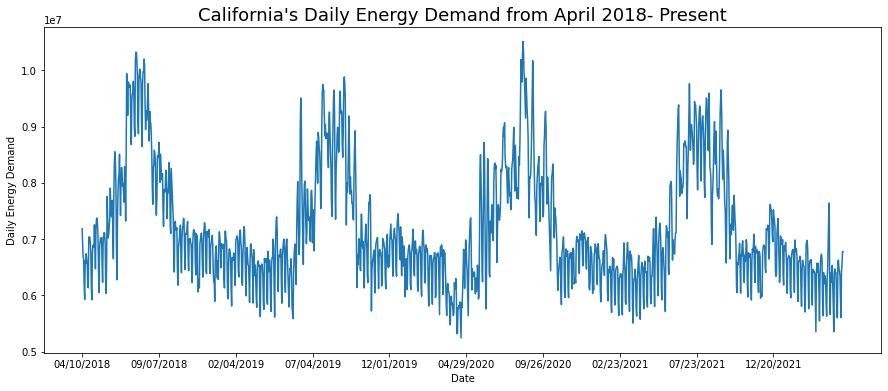

In [35]:
plt.figure(figsize=(15,6))
plt.title("California's Daily Energy Demand from April 2018- Present", fontsize=18)
plt.xticks(np.arange(0, len(masterdf), 150))
sns.lineplot( x ='Date', y= 'Daily Energy Demand', data = masterdf) 

Much better use of white space!

### 2.3 Visualizing Changes in Energy Demand Over Time

Looking at the entire time period in the line plot above, there appears to be four peaks in the data around the summer each year, as well as daily variations. Let's look at these trends in more detail.

<AxesSubplot:title={'center':'Daily Energy Demand Over a Two Week Period in Sept 2018'}, xlabel='Date', ylabel='Daily Energy Demand'>

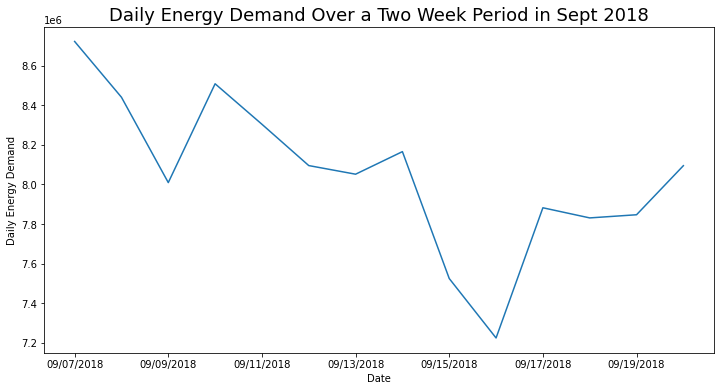

In [36]:
plt.figure(figsize=(12,6))
plt.title("Daily Energy Demand Over a Two Week Period in Sept 2018", fontsize=18)
plt.xticks(np.arange(0, 14, 2))
sns.lineplot( x ='Date', y= 'Daily Energy Demand', data = masterdf.iloc[150:164,:]) 

Looking at a random 2 week period, it seems like the days of the week are going to significantly impact the energy demand. Let's create a feature for the day of the week.

#### 2.3.1 Feature Engineering- Day

In [37]:
masterdf['Date_DateObj']

0       2018-04-10
1       2018-04-11
2       2018-04-12
3       2018-04-13
4       2018-04-14
           ...    
1482    2022-05-01
1483    2022-05-02
1484    2022-05-03
1485    2022-05-04
1486    2022-05-05
Name: Date_DateObj, Length: 1487, dtype: object

Want masterdf['Date_DateObj'] to be dtype: datetime64 so I can call a day_name() function on it

In [38]:
masterdf['Date_DateObj'] = pd.to_datetime((masterdf['Date']))
masterdf['Date_DateObj']

0      2018-04-10
1      2018-04-11
2      2018-04-12
3      2018-04-13
4      2018-04-14
          ...    
1482   2022-05-01
1483   2022-05-02
1484   2022-05-03
1485   2022-05-04
1486   2022-05-05
Name: Date_DateObj, Length: 1487, dtype: datetime64[ns]

In [39]:
masterdf['Day']=masterdf['Date_DateObj'].dt.day_name()

In [40]:
masterdf.head(15)

,Date,Date_DateObj,Day,Daily Energy Demand
0,04/10/2018,2018-04-10,Tuesday,7183786.0
1,04/11/2018,2018-04-11,Wednesday,6927243.5
2,04/12/2018,2018-04-12,Thursday,6670701.0
3,04/13/2018,2018-04-13,Friday,6643068.0
4,04/14/2018,2018-04-14,Saturday,6183992.0
5,04/15/2018,2018-04-15,Sunday,5926078.0
6,04/16/2018,2018-04-16,Monday,6619344.0
7,04/17/2018,2018-04-17,Tuesday,6567013.0
8,04/18/2018,2018-04-18,Wednesday,6739403.0
9,04/19/2018,2018-04-19,Thursday,6649368.0


I will specify the order of the week to set the x-axis order.

In [41]:
dayorder= ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

<AxesSubplot:title={'center':'Weekly Average Energy Demand 2018-2022'}, xlabel='Day', ylabel='Daily Energy Demand'>

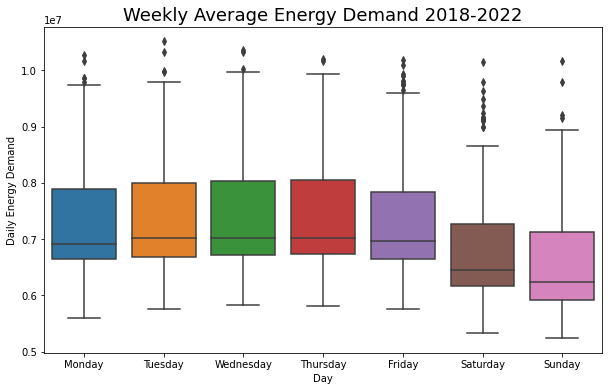

In [42]:
plt.figure(figsize=(10,6))
plt.title("Weekly Average Energy Demand 2018-2022", fontsize=18)
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
sns.boxplot(data = masterdf, x= 'Day', y='Daily Energy Demand', order= dayorder)

 Looks like the day of the week will be an important feature when forecasting energy demand. Energy demand is fairly consistent Tuesdays-Thursdays, with a slight decrease on Fridays and Mondays, and then a more substantial decrease on Saturdays and Sundays. Perhaps holiday weekends play a role in affecting Monday and Friday demand.

In [43]:
masterdf.groupby('Day')['Daily Energy Demand'].describe()

,count,mean,std,min,25%,50%,75%,max
Day,,,,,,,,
Friday,212.0,7.329996e+06,1.012470e+06,5761548.0,6654858.50,6957308.5,7838852.75,10191567.0
Monday,212.0,7.291811e+06,9.735526e+05,5588912.0,6641524.50,6918368.0,7884397.25,10279193.5
Saturday,212.0,6.833514e+06,9.975255e+05,5324575.0,6166557.00,6450973.0,7263619.75,10157171.0
Sunday,212.0,6.583806e+06,9.695501e+05,5242117.0,5911875.25,6228817.0,7131665.25,10171423.0
Thursday,213.0,7.399925e+06,9.778606e+05,5803203.0,6731143.00,7015855.0,8051625.00,10200932.0
Tuesday,213.0,7.391888e+06,9.840393e+05,5764182.0,6686602.00,7023700.0,7993980.00,10513638.5
Wednesday,213.0,7.414909e+06,9.837481e+05,5820272.0,6721777.00,7027449.0,8029561.00,10355162.5


The statistics above are used to calculate the values in the boxplot. Note that the std is highest for Fridays, further suggesting holiday weekends may cause fluctuation in demand.

#### 2.3.2 Feature Engineering- Month

Creating a feature for month using the month_name function

In [44]:
masterdf['Month'] = masterdf['Date_DateObj'].dt.month_name()

Specifying the month order for plotting

In [45]:
monthorder= ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

<AxesSubplot:title={'center':"California's Monthly Average Energy Demand 2018-2022"}, xlabel='Month', ylabel='Daily Energy Demand'>

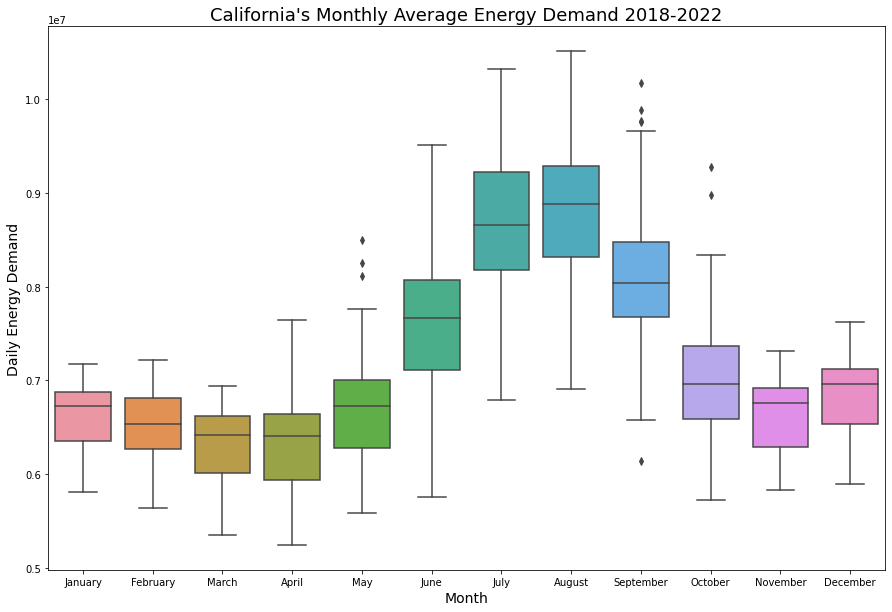

In [46]:
plt.figure(figsize=(15,10))
plt.title("California's Monthly Average Energy Demand 2018-2022", fontsize=18)
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
sns.boxplot(data = masterdf, x= 'Month', y='Daily Energy Demand', order= monthorder)

Unsurprisingly, summer has the most energy demand, likely due to the use of air conditioning. Some outlying data points in May, September and October may be caused by unusually hot days. The effect of holiday breaks, such as those in December, is not clear at this point but may be counteracted by colder temperatures that have people turning on their heating systems more.

In [47]:
masterdf.groupby('Month')['Daily Energy Demand'].describe()

,count,mean,std,min,25%,50%,75%,max
Month,,,,,,,,
April,141.0,6.347513e+06,473008.087230,5242117.0,5937591.00,6409634.0,6643068.00,7638350.0
August,124.0,8.843042e+06,757050.465129,6905232.0,8320416.75,8879101.5,9289813.25,10513638.5
December,124.0,6.868592e+06,358262.903958,5893254.0,6537343.75,6960129.5,7117728.25,7618952.0
February,113.0,6.504537e+06,389272.330884,5642251.0,6271296.00,6532427.0,6809994.00,7221650.0
January,124.0,6.619063e+06,338727.128118,5810743.0,6353226.25,6720612.0,6875809.25,7174229.0
July,124.0,8.665619e+06,801693.007885,6790239.0,8181121.25,8659204.0,9224283.75,10325573.5
June,120.0,7.635755e+06,732388.115654,5756188.0,7106883.25,7662919.0,8073755.25,9508169.0
March,124.0,6.331962e+06,381818.228675,5350644.0,6012158.00,6414205.5,6614136.75,6940731.0
May,129.0,6.664921e+06,531614.866897,5588912.0,6277977.00,6721941.0,6999848.00,8501267.0


#### 2.3.3 Feature Engineering- Year

Creating a year feature.

We know that the first and final years in the data set are incomplete, so having the ability to seperate by year is important. Additionally, it will be interesting to see how demand has changed over the years.

In [48]:
masterdf['Year']= masterdf['Date_DateObj'].dt.year

In [49]:
masterdf.head(2)

,Date,Date_DateObj,Day,Daily Energy Demand,Month,Year
0,04/10/2018,2018-04-10,Tuesday,7183786.0,April,2018
1,04/11/2018,2018-04-11,Wednesday,6927243.5,April,2018


Since both 2018 and 2022 are incomplete, let's first look at a boxplot of the complete years 

<AxesSubplot:title={'center':"California's Yearly Energy Demand"}, xlabel='Year', ylabel='Daily Energy Demand'>

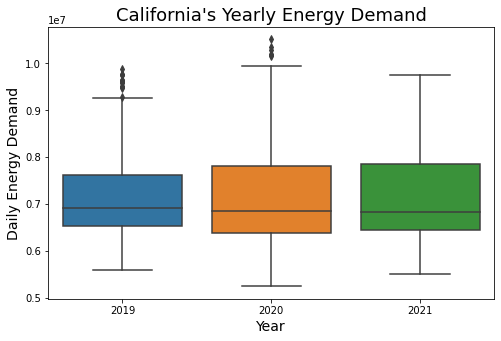

In [50]:
plt.figure(figsize=(8,5))
plt.title("California's Yearly Energy Demand", fontsize = 18)
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
full_years = masterdf[(masterdf['Year']== 2019) | (masterdf['Year']== 2020)| (masterdf['Year']== 2021)]          
sns.boxplot(data = full_years, x= 'Year', y='Daily Energy Demand')

Both 2020 and 2021 had higher energy demand than 2019. It is notable that despite disruptions caused by COVID-19 in 2020, the energy demand for 2021 is about equal to the demand in 2020.

<AxesSubplot:title={'center':'Note:2018 is missing data from Jan-March'}, xlabel='Month', ylabel='Daily Energy Demand'>

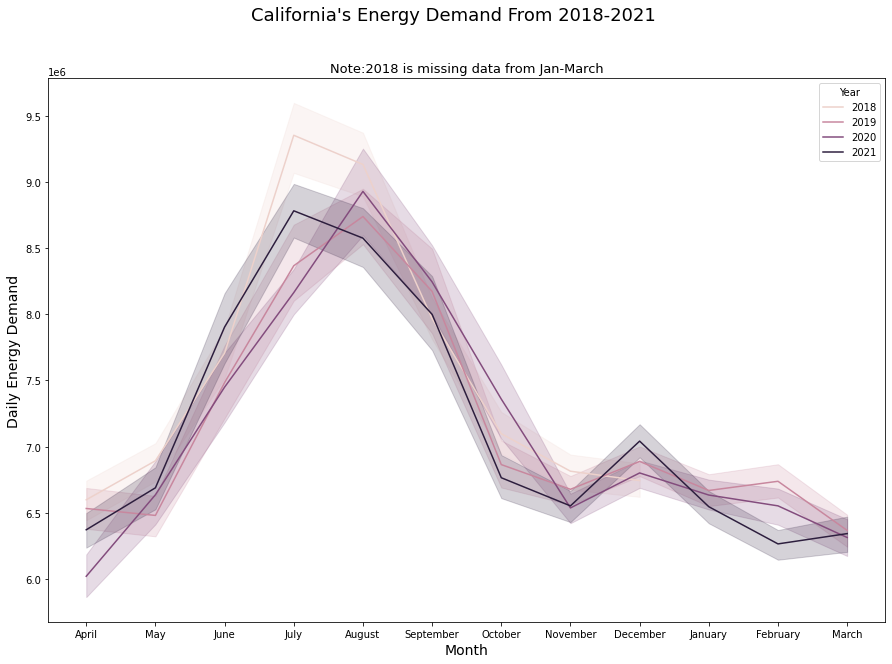

In [51]:
plt.figure(figsize=(15,10))
plt.suptitle("California's Energy Demand From 2018-2021", fontsize = 18)
plt.title("Note:2018 is missing data from Jan-March", fontsize = 13)
lineplotdata=masterdf[(masterdf['Year'] != 2022)]
sns.lineplot(data=lineplotdata, x='Month', y='Daily Energy Demand', hue='Year')

Looking at the energy demand each month, it appears that there is a decent amount of fluctuation from year to year. 

A more straight-forward way to see this fluctuation is by plotting one month at a time. 

Take July for example:

<AxesSubplot:title={'center':'CA Energy Demand in July'}, xlabel='Year', ylabel='Daily Energy Demand'>

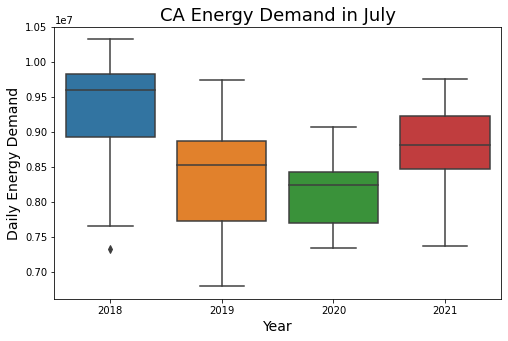

In [52]:
plt.figure(figsize=(8,5))
plt.title("CA Energy Demand in July", fontsize = 18)
july_e = masterdf[(masterdf['Month']== 'July')]   
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
sns.boxplot(data = july_e, x= 'Year', y='Daily Energy Demand')

The monthly trends for July highlight the fluctuation between years, especially given the inverse trend observed in this graph as opposed to the Yearly Energy Demand Graph that showed 2020 and 2021 as about equal and 2019 as having less energy demand.

This highlights the importance of considering weather data in the forecasting of energy demand.

In [53]:
masterdf

,Date,Date_DateObj,Day,Daily Energy Demand,Month,Year
0,04/10/2018,2018-04-10,Tuesday,7183786.0,April,2018
1,04/11/2018,2018-04-11,Wednesday,6927243.5,April,2018
2,04/12/2018,2018-04-12,Thursday,6670701.0,April,2018
3,04/13/2018,2018-04-13,Friday,6643068.0,April,2018
4,04/14/2018,2018-04-14,Saturday,6183992.0,April,2018
...,...,...,...,...,...,...
1482,05/01/2022,2022-05-01,Sunday,5602391.0,May,2022
1483,05/02/2022,2022-05-02,Monday,6418406.0,May,2022
1484,05/03/2022,2022-05-03,Tuesday,6544626.0,May,2022
1485,05/04/2022,2022-05-04,Wednesday,6777355.0,May,2022


## Incorporating Weather Data

In [54]:
list(masterdf.columns.values)

['Date', 'Date_DateObj', 'Day', 'Daily Energy Demand', 'Month', 'Year']

Reordering columns to keep all date-related columns next to each other

In [55]:
masterdf= masterdf[['Date', 'Date_DateObj', 'Day', 'Month', 'Year', 'Daily Energy Demand']]

In [56]:
masterdf.head(3)

,Date,Date_DateObj,Day,Month,Year,Daily Energy Demand
0,04/10/2018,2018-04-10,Tuesday,April,2018,7183786.0
1,04/11/2018,2018-04-11,Wednesday,April,2018,6927243.5
2,04/12/2018,2018-04-12,Thursday,April,2018,6670701.0


In [57]:
maxtempdf=pd.read_csv('MaxTempData.csv', index_col=0)

In [58]:
maxtempdf

,Date,Max Temp,Station ID,Station Location
0,2018-01-01,67.0,GHCND:USW00023174,Los Angeles International Airport
1,2018-01-02,76.0,GHCND:USW00023174,Los Angeles International Airport
2,2018-01-03,76.0,GHCND:USW00023174,Los Angeles International Airport
3,2018-01-04,74.0,GHCND:USW00023174,Los Angeles International Airport
4,2018-01-05,69.0,GHCND:USW00023174,Los Angeles International Airport
...,...,...,...,...
10766,2022-05-08,68.0,GHCND:USW00003102,Ontario Airport
10767,2022-05-09,69.0,GHCND:USW00003102,Ontario Airport
10768,2022-05-10,72.0,GHCND:USW00003102,Ontario Airport
10769,2022-05-11,71.0,GHCND:USW00003102,Ontario Airport


In [59]:
maxtempdf['Date']

0        2018-01-01
1        2018-01-02
2        2018-01-03
3        2018-01-04
4        2018-01-05
            ...    
10766    2022-05-08
10767    2022-05-09
10768    2022-05-10
10769    2022-05-11
10770    2022-05-12
Name: Date, Length: 10771, dtype: object

In [60]:
maxtempdf['Date'] = pd.to_datetime((maxtempdf['Date']))

In [61]:
maxtempdf['Date']

0       2018-01-01
1       2018-01-02
2       2018-01-03
3       2018-01-04
4       2018-01-05
           ...    
10766   2022-05-08
10767   2022-05-09
10768   2022-05-10
10769   2022-05-11
10770   2022-05-12
Name: Date, Length: 10771, dtype: datetime64[ns]

Need to set the datetime feature as the index so we can use the `.join()` method with the energy data frame

In [62]:
maxtempdf = maxtempdf.set_index('Date')

In [63]:
masterdf.head()

,Date,Date_DateObj,Day,Month,Year,Daily Energy Demand
0,04/10/2018,2018-04-10,Tuesday,April,2018,7183786.0
1,04/11/2018,2018-04-11,Wednesday,April,2018,6927243.5
2,04/12/2018,2018-04-12,Thursday,April,2018,6670701.0
3,04/13/2018,2018-04-13,Friday,April,2018,6643068.0
4,04/14/2018,2018-04-14,Saturday,April,2018,6183992.0


In [64]:
masterdf = masterdf.set_index('Date_DateObj')

In [65]:
masterdf2= masterdf.join(maxtempdf)

Important to note that this is a left join by default, which is what we want because we have a larger date range in the temp data than in the energy data.

In [66]:
masterdf2

,Date,Day,Month,Year,Daily Energy Demand,Max Temp,Station ID,Station Location
2018-04-10,04/10/2018,Tuesday,April,2018,7183786.0,79.0,GHCND:USW00023174,Los Angeles International Airport
2018-04-10,04/10/2018,Tuesday,April,2018,7183786.0,85.0,GHCND:USW00023188,San Diego Airport
2018-04-10,04/10/2018,Tuesday,April,2018,7183786.0,63.0,GHCND:USW00023272,San Francisco Downtown
2018-04-10,04/10/2018,Tuesday,April,2018,7183786.0,86.0,GHCND:USW00093193,FRESNO YOSEMITE INTERNATIONAL
2018-04-10,04/10/2018,Tuesday,April,2018,7183786.0,69.0,GHCND:USW00023293,San Jose
...,...,...,...,...,...,...,...,...
2022-05-05,05/05/2022,Thursday,May,2022,6777355.0,59.0,GHCND:USW00023272,San Francisco Downtown
2022-05-05,05/05/2022,Thursday,May,2022,6777355.0,91.0,GHCND:USW00093193,FRESNO YOSEMITE INTERNATIONAL
2022-05-05,05/05/2022,Thursday,May,2022,6777355.0,77.0,GHCND:USW00093225,SACRAMENTO METROPOLITAN AIRPORT
2022-05-05,05/05/2022,Thursday,May,2022,6777355.0,74.0,GHCND:USW00023293,San Jose


Great! Now all the dates are the same as what we examined for the energy demand data in the initial visuations, but we now have max temperature readings for those dates.
Now I need to add in the minimum temperature values, but since that dataframe will have a few key columns, it will make more sense to use the `.merge()` method.

In [67]:
mintempdf=pd.read_csv('MinTempData.csv', index_col=0)

In [68]:
mintempdf['Date'] = pd.to_datetime((mintempdf['Date']))
mintempdf = mintempdf.set_index('Date')

In [69]:
mintempdf.head()

,Min Temp,Station ID,Station Location
Date,,,
2018-01-01,48.0,GHCND:USW00023174,Los Angeles International Airport
2018-01-02,54.0,GHCND:USW00023174,Los Angeles International Airport
2018-01-03,54.0,GHCND:USW00023174,Los Angeles International Airport
2018-01-04,55.0,GHCND:USW00023174,Los Angeles International Airport
2018-01-05,56.0,GHCND:USW00023174,Los Angeles International Airport


In [70]:
masterdf2.loc['04/10/2018']

,Date,Day,Month,Year,Daily Energy Demand,Max Temp,Station ID,Station Location
2018-04-10,04/10/2018,Tuesday,April,2018,7183786.0,79.0,GHCND:USW00023174,Los Angeles International Airport
2018-04-10,04/10/2018,Tuesday,April,2018,7183786.0,85.0,GHCND:USW00023188,San Diego Airport
2018-04-10,04/10/2018,Tuesday,April,2018,7183786.0,63.0,GHCND:USW00023272,San Francisco Downtown
2018-04-10,04/10/2018,Tuesday,April,2018,7183786.0,86.0,GHCND:USW00093193,FRESNO YOSEMITE INTERNATIONAL
2018-04-10,04/10/2018,Tuesday,April,2018,7183786.0,69.0,GHCND:USW00023293,San Jose
2018-04-10,04/10/2018,Tuesday,April,2018,7183786.0,94.0,GHCND:USW00003102,Ontario Airport


Creating a column of both dataframe index values so it can be used to merge on, in addition to the  key columns of Station Location and Station ID

In [71]:
masterdf2['indexdate'] = masterdf2.index.values
mintempdf['indexdate'] = mintempdf.index.values

In [72]:
masterdf2

,Date,Day,Month,Year,Daily Energy Demand,Max Temp,Station ID,Station Location,indexdate
2018-04-10,04/10/2018,Tuesday,April,2018,7183786.0,79.0,GHCND:USW00023174,Los Angeles International Airport,2018-04-10
2018-04-10,04/10/2018,Tuesday,April,2018,7183786.0,85.0,GHCND:USW00023188,San Diego Airport,2018-04-10
2018-04-10,04/10/2018,Tuesday,April,2018,7183786.0,63.0,GHCND:USW00023272,San Francisco Downtown,2018-04-10
2018-04-10,04/10/2018,Tuesday,April,2018,7183786.0,86.0,GHCND:USW00093193,FRESNO YOSEMITE INTERNATIONAL,2018-04-10
2018-04-10,04/10/2018,Tuesday,April,2018,7183786.0,69.0,GHCND:USW00023293,San Jose,2018-04-10
...,...,...,...,...,...,...,...,...,...
2022-05-05,05/05/2022,Thursday,May,2022,6777355.0,59.0,GHCND:USW00023272,San Francisco Downtown,2022-05-05
2022-05-05,05/05/2022,Thursday,May,2022,6777355.0,91.0,GHCND:USW00093193,FRESNO YOSEMITE INTERNATIONAL,2022-05-05
2022-05-05,05/05/2022,Thursday,May,2022,6777355.0,77.0,GHCND:USW00093225,SACRAMENTO METROPOLITAN AIRPORT,2022-05-05
2022-05-05,05/05/2022,Thursday,May,2022,6777355.0,74.0,GHCND:USW00023293,San Jose,2022-05-05


In [73]:
masterdf3 = pd.merge(masterdf2, mintempdf, how = 'inner', on= ['indexdate', 'Station ID', 'Station Location'])

In [74]:
masterdf3

,Date,Day,Month,Year,Daily Energy Demand,Max Temp,Station ID,Station Location,indexdate,Min Temp
0,04/10/2018,Tuesday,April,2018,7183786.0,79.0,GHCND:USW00023174,Los Angeles International Airport,2018-04-10,60.0
1,04/10/2018,Tuesday,April,2018,7183786.0,85.0,GHCND:USW00023188,San Diego Airport,2018-04-10,60.0
2,04/10/2018,Tuesday,April,2018,7183786.0,63.0,GHCND:USW00023272,San Francisco Downtown,2018-04-10,52.0
3,04/10/2018,Tuesday,April,2018,7183786.0,86.0,GHCND:USW00093193,FRESNO YOSEMITE INTERNATIONAL,2018-04-10,59.0
4,04/10/2018,Tuesday,April,2018,7183786.0,69.0,GHCND:USW00023293,San Jose,2018-04-10,52.0
...,...,...,...,...,...,...,...,...,...,...
10126,05/05/2022,Thursday,May,2022,6777355.0,59.0,GHCND:USW00023272,San Francisco Downtown,2022-05-05,49.0
10127,05/05/2022,Thursday,May,2022,6777355.0,91.0,GHCND:USW00093193,FRESNO YOSEMITE INTERNATIONAL,2022-05-05,62.0
10128,05/05/2022,Thursday,May,2022,6777355.0,77.0,GHCND:USW00093225,SACRAMENTO METROPOLITAN AIRPORT,2022-05-05,52.0
10129,05/05/2022,Thursday,May,2022,6777355.0,74.0,GHCND:USW00023293,San Jose,2022-05-05,51.0


Great! Looks like we lost two rows, which is why we used an inner join because we knew the minimum temp data was two data points shorter than the max temp data.

Now to tidy up the dataframe a bit

In [75]:
masterdf3['Date-DateTime'] = masterdf3['indexdate'] 

In [76]:
masterdf3.drop('indexdate', axis=1, inplace=True)

In [77]:
list(masterdf3.columns.values)

['Date',
 'Day',
 'Month',
 'Year',
 'Daily Energy Demand',
 'Max Temp',
 'Station ID',
 'Station Location',
 'Min Temp',
 'Date-DateTime']

In [78]:
masterdf3 = masterdf3[[ 'Date-DateTime', 'Date', 'Day', 'Month', 'Year',
 'Daily Energy Demand', 'Max Temp', 'Min Temp', 'Station Location', 'Station ID']]

In [83]:
masterdf3['Station Location'].nunique()

7

In [84]:
cleaned_cities = {'Los Angeles International Airport': 'Los Angeles Coastal', 'San Diego Airport': 'San Diego', 'San Francisco Downtown': 'San Francisco', 'FRESNO YOSEMITE INTERNATIONAL': 'Fresno', 
                 'San Jose': 'San Jose', 'Ontario Airport': 'Los Angeles Inland', 'SACRAMENTO METROPOLITAN AIRPORT': 'Sacramento'}

In [85]:
masterdf3['Station Location']= masterdf3['Station Location'].map(cleaned_cities)

In [86]:
masterdf3['Station Location'].nunique()

7

In [87]:
masterdf3.to_csv('WeatherandEnergyData.csv')

In [89]:
masterdf3.head(7)

,Date-DateTime,Date,Day,Month,Year,Daily Energy Demand,Max Temp,Min Temp,Station Location,Station ID
0,2018-04-10,04/10/2018,Tuesday,April,2018,7183786.0,79.0,60.0,Los Angeles Coastal,GHCND:USW00023174
1,2018-04-10,04/10/2018,Tuesday,April,2018,7183786.0,85.0,60.0,San Diego,GHCND:USW00023188
2,2018-04-10,04/10/2018,Tuesday,April,2018,7183786.0,63.0,52.0,San Francisco,GHCND:USW00023272
3,2018-04-10,04/10/2018,Tuesday,April,2018,7183786.0,86.0,59.0,Fresno,GHCND:USW00093193
4,2018-04-10,04/10/2018,Tuesday,April,2018,7183786.0,69.0,52.0,San Jose,GHCND:USW00023293
5,2018-04-10,04/10/2018,Tuesday,April,2018,7183786.0,94.0,60.0,Los Angeles Inland,GHCND:USW00003102
6,2018-04-11,04/11/2018,Wednesday,April,2018,6927243.5,74.0,57.0,Los Angeles Coastal,GHCND:USW00023174
